In [11]:
#importing necessaary files:
!pip install GetOldTweets3
import pandas as pd
import numpy as np
import re
from pprint import pprint
from datetime import datetime
import GetOldTweets3 as got
import time

In [12]:


# for plotting purpose importing the packages:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
# defining function to pass the query and to extarct data in columns:
def get_tweets(text_query, start_date, end_date, lang, location, within):
       tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                                                 .setSince(start_date)\
                                                 .setUntil(end_date)\
                                                 .setLang(lang)\
                                                 .setNear(location)\
                                                 .setWithin(within)\
                                                 
       #Scrapping tweets based on criteria
       tweet = got.manager.TweetManager.getTweets(tweetCriteria)


       #creating list of tweets with the tweet attributes:
       text_tweets =[[tw.username, 
                      tw.text,
                      tw.date,
                      tw.retweets,
                      tw.favorites,
                      tw.hashtags] for tw in tweet]

       # creating dataframe, assigning column names to list of
       # tweets corresponding to tweet attributes
       tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User','Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
       return tw_df
    

In [14]:
# set attributes needed for get_tweets
text_query = '#belletstalk',

text_query = str(text_query)
start_date = '2019-10-05'
end_date = '2020-07-12'
lang = 'en'
within = '50mi'

citys = ['New York City, New York','Boston, Massachusetts','Chicago, Illinois','Detroit, Michigan','Los Angeles, California',
         'Houston, Texas','Newark, New Jersey','Miami, Florida','Philadelphia, Pennsylvania', 'Detroit,  Michigan','Seattle, Washington',
               'Washington, DC','San Jose, California','Oakland, California','St. Petersburg, Florida' ,'Glendale, Arizona','New Orleans, Louisiana','Phoenix, Arizona',
         '	Charlotte, North Carolina' ]# export our raw data

In [15]:
#scrapping needed info and assing it into csv file:
for city in citys:
    location = city
    df = get_tweets(text_query, start_date, end_date, lang, location, within)
    df.to_csv(city + 'belletstalk.csv', index=False)
  
    

In [16]:
#adding city column to combine all datasets:
city_column = ['NY', 'BOSTON', 'CHI', 'DETROIT', 'LA', 'HOUSTON', 'NEWARK', 'MIA', 'PHIL', 'SEATTLE','WA','SJ','O-TOWN','SPB','GEU','NOLA','PHOENIX','CHARLOTTE']
alone = pd.DataFrame()
for i in range(len(city_column)):
     df = pd.read_csv(citys[i] + '.csv')
     df['City'] = city_column[i]
     alone = pd.concat([alone, df], axis = 0)

In [17]:
#exporting the raw data:
alone.to_csv('belletstalk.csv', index=False)

In [18]:
# importing the dataset:
df = pd.read_csv('belletstalk.csv')
df.shape

(828, 7)

In [40]:
df.head(10)

,User,Text,Retweets,Favorites,HashTags,City,date,time
9,victorpsanchez,Have you watched this? @HowtoADHD powerful tes...,0,2,#ADHD,New York,2020-05-25,21-04-40
12,Riddagh,Hallelujah by Jeff Buckley . . . #music #sooth...,0,0,#music #soothing #hallelujah #amen #jeffbuckle...,New York,2020-05-19,21-29-35
14,victorpsanchez,Great online presentation and discussion on ne...,2,4,#adhd,New York,2020-05-04,14-07-51
23,niccib28,I got out of bed at 2:00 pm. Decided to clean ...,0,0,#quarantine #dressup #costumes #cleaningoutthe...,New York,2020-04-04,23-34-50
24,Riddagh,I want to look good after all the quarantine i...,0,0,#shameless #shirtless #selfie #quarantine #cor...,New York,2020-04-03,17-44-12
25,Riddagh,"Just a boy on a fire escape, trying to escape ...",0,1,#photoshoot #nyc #actor #quarentine #coronavir...,New York,2020-03-28,21-26-36
26,MillennialMuse1,#newmusicfridays What album we excited to put ...,2,3,#newmusicfridays #arilennox #sheabutterbabyrem...,New York,2020-03-27,15-15-56
27,katecoriell,I’ve been primarily remote for a couple years ...,0,3,#Neurodiversity #ADHD #Socialmediadistancing,New York,2020-03-19,01-06-14
28,Subilak,Please watch. Here is one of the many reasons ...,0,0,#nerurodiverse #ADHD #Neurofeedback,New York,2020-02-26,16-26-49
29,HealthEugene,I got #podcast #ADHD - so much great stuff out...,0,0,#podcast #ADHD #juatsaying,New York,2020-02-25,13-44-19


In [19]:
# remove duplicates
df.replace('[]', np.nan,inplace=True)
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

# devide timestamp into date and time
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'],axis = 1, inplace =True)

# replace city initials with city names
replace_values = {'NY' : 'New York', 'BOSTON' : 'Boston', 'CHI' : 'Chicago', 'DETROIT' : 'Detroit', 'HOUSTON' : 'Houston',
                  'LA' : 'Los Angeles', 'MIA' : 'Miami', 'NEWARK' : 'Newark', 'NEW ORLEANS' : 'New Orleans', 'PHIL' : 'Philadelphia',
                  'SEATTLE':'seattle','WA':'washington','SJ':'San Jose','O-TOWN':'OakLand','SPB':'Saint Petersburg',
                  'GEU':'Glendale','NOLA':'New Orleans','PHOENIX':'phoenix','CHARLOTTE':'charlottte'}                                                                                          
df = df.replace({"City": replace_values})

In [20]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

In [21]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-06-30,2,2,1.000000,253,0
2020-07-02,1,4,4.000000,255,2
2020-07-03,1,1,1.000000,255,0
2020-07-04,3,4,1.333333,256,1
2020-07-05,2,4,2.000000,256,0
2020-07-06,2,4,2.000000,256,0
2020-07-08,1,1,1.000000,257,1
2020-07-09,4,4,1.000000,258,1
2020-07-10,3,3,1.000000,258,0


In [31]:
# select '2020-04-06' as division
# old users: who started to be active before 04-06
# new_users: who weren't active until 04-06
existing_user= df[df['date'] < '2020-04-06']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(80)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("belletstalk.csv", index = False)
df.shape

(684, 8)

[Text(0, 0, '2019-10-05'),
 Text(0, 0, '2019-10-06'),
 Text(0, 0, '2019-10-07'),
 Text(0, 0, '2019-10-08'),
 Text(0, 0, '2019-10-09'),
 Text(0, 0, '2019-10-10'),
 Text(0, 0, '2019-10-11'),
 Text(0, 0, '2019-10-12'),
 Text(0, 0, '2019-10-14'),
 Text(0, 0, '2019-10-15'),
 Text(0, 0, '2019-10-16'),
 Text(0, 0, '2019-10-17'),
 Text(0, 0, '2019-10-18'),
 Text(0, 0, '2019-10-19'),
 Text(0, 0, '2019-10-21'),
 Text(0, 0, '2019-10-22'),
 Text(0, 0, '2019-10-23'),
 Text(0, 0, '2019-10-24'),
 Text(0, 0, '2019-10-25'),
 Text(0, 0, '2019-10-26'),
 Text(0, 0, '2019-10-27'),
 Text(0, 0, '2019-10-28'),
 Text(0, 0, '2019-10-29'),
 Text(0, 0, '2019-10-30'),
 Text(0, 0, '2019-10-31'),
 Text(0, 0, '2019-11-02'),
 Text(0, 0, '2019-11-04'),
 Text(0, 0, '2019-11-05'),
 Text(0, 0, '2019-11-06'),
 Text(0, 0, '2019-11-07'),
 Text(0, 0, '2019-11-08'),
 Text(0, 0, '2019-11-09'),
 Text(0, 0, '2019-11-10'),
 Text(0, 0, '2019-11-11'),
 Text(0, 0, '2019-11-12'),
 Text(0, 0, '2019-11-13'),
 Text(0, 0, '2019-11-14'),
 

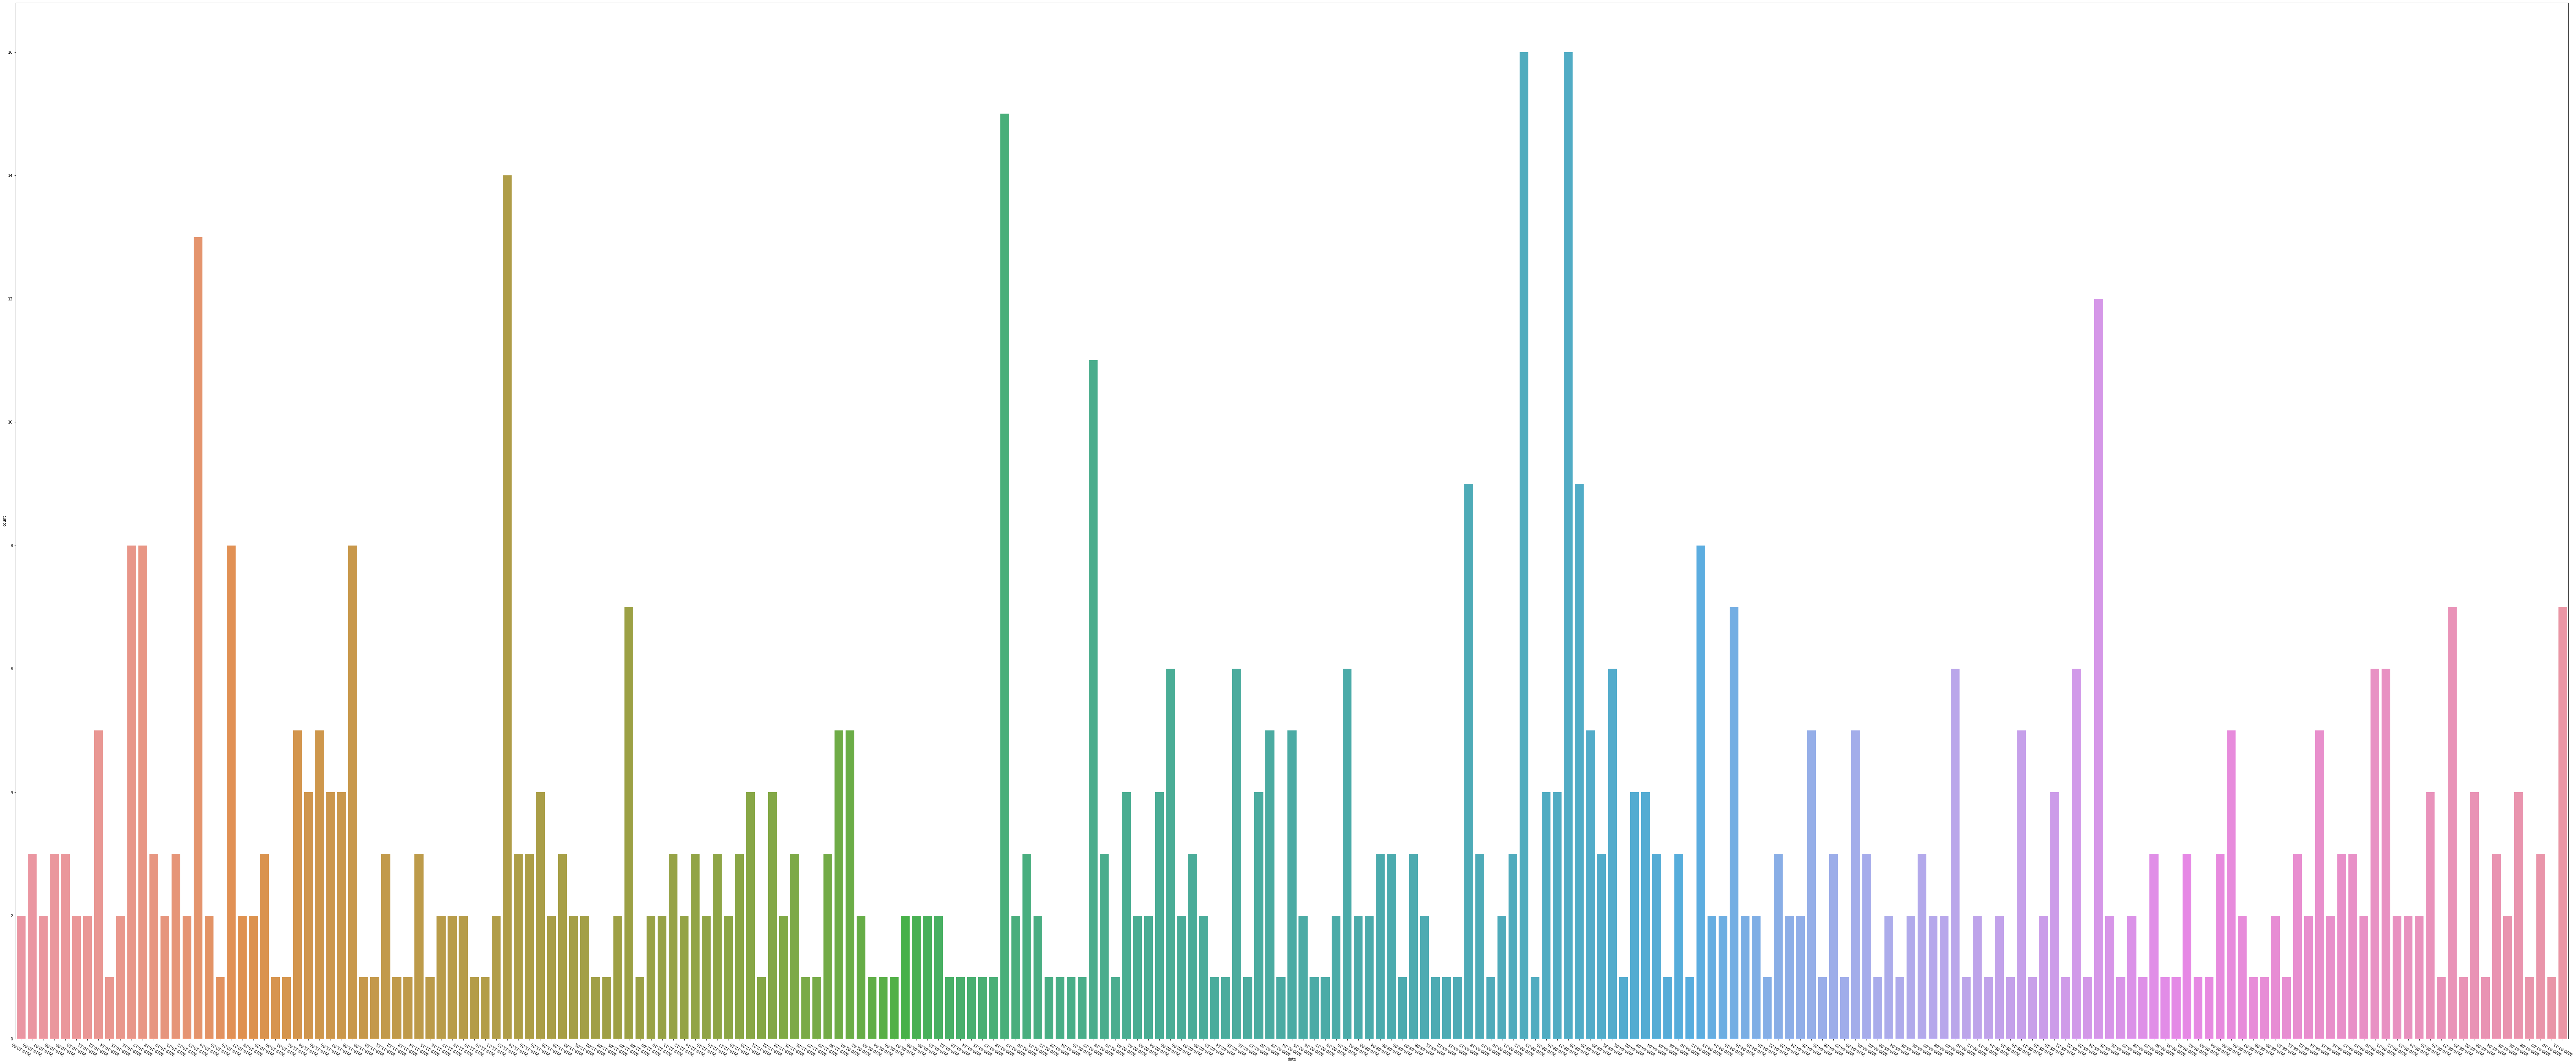

In [39]:
# plot the distribution of our new sample
fig = plt.figure(figsize = (120,50))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 150)

In [33]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]


In [34]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-06-30,1,1,1.000000,231,0
2020-07-02,1,4,4.000000,232,1
2020-07-03,1,1,1.000000,232,0
2020-07-04,2,3,1.500000,233,1
2020-07-05,2,2,1.000000,233,0
2020-07-06,2,4,2.000000,233,0
2020-07-08,1,1,1.000000,234,1
2020-07-09,3,3,1.000000,235,1
2020-07-10,1,1,1.000000,235,0
